In [ ]:
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline  

In [ ]:
import os 
from glob import glob

INPUT_PATH = '../'
DATA_PATH = INPUT_PATH
TRAIN_DATA = os.path.join(DATA_PATH, "train")
TRAIN_MASKS_DATA = os.path.join(DATA_PATH, "train_masks")
TEST_DATA = os.path.join(DATA_PATH, "test")
TRAIN_MASKS_CSV_FILEPATH = os.path.join(DATA_PATH, "train_masks.csv")
METADATA_CSV_FILEPATH = os.path.join(DATA_PATH, "metadata.csv")

TRAIN_MASKS_CSV = pd.read_csv(TRAIN_MASKS_CSV_FILEPATH)
METADATA_CSV = pd.read_csv(METADATA_CSV_FILEPATH)

In [ ]:
train_files = glob(os.path.join(TRAIN_DATA, "*.jpg"))
train_ids = [s[len(TRAIN_DATA)+1:-4] for s in train_files]

test_files = glob(os.path.join(TEST_DATA, "*.jpg"))
test_ids = [s[len(TEST_DATA)+1:-4] for s in test_files]

In [ ]:
def get_filename(image_id, image_type):
    check_dir = False
    if "Train" == image_type:
        ext = 'jpg'
        data_path = TRAIN_DATA
        suffix = ''
    elif "Train_mask" in image_type:
        ext = 'gif'
        data_path = TRAIN_MASKS_DATA
        suffix = '_mask'
    elif "Test" in image_type:
        ext = 'jpg'
        data_path = TEST_DATA
        suffix = ''
    else:
        raise Exception("Image type '%s' is not recognized" % image_type)

    if check_dir and not os.path.exists(data_path):
        os.makedirs(data_path)

    return os.path.join(data_path, "{}{}.{}".format(image_id, suffix, ext))

In [ ]:
import cv2
from PIL import Image


def get_image_data(image_id, image_type, **kwargs):
    if 'mask' in image_type:
        img = _get_image_data_pil(image_id, image_type, **kwargs)
    else:
        img = _get_image_data_opencv(image_id, image_type, **kwargs)
    return img

def _get_image_data_opencv(image_id, image_type, **kwargs):
    fname = get_filename(image_id, image_type)
    img = cv2.imread(fname)
    assert img is not None, "Failed to read image : %s, %s" % (image_id, image_type)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if True:
        img = cv2.resize(img,(512, 512))
    return img


def _get_image_data_pil(image_id, image_type, return_exif_md=False, return_shape_only=False):
    fname = get_filename(image_id, image_type)
    try:
        img_pil = Image.open(fname)
    except Exception as e:
        assert False, "Failed to read image : %s, %s. Error message: %s" % (image_id, image_type, e)

    if return_shape_only:
        return img_pil.size[::-1] + (len(img_pil.getbands()),)

    if True:
        img_pil = img_pil.resize((512, 512))
    img = np.asarray(img_pil)
    assert isinstance(img, np.ndarray), "Open image is not an ndarray. Image id/type : %s, %s" % (image_id, image_type)
    if not return_exif_md:
        return img
    else:
        return img, img_pil._getexif()

In [ ]:
image_id = train_ids[0]

img = get_image_data(image_id, "Train")

In [ ]:
mask = get_image_data(image_id, "Train_mask")

In [ ]:
plt.imshow(img)

In [ ]:
model = keras.Sequential()

model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=img.shape))
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)))
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)))

In [1]:
%matplotlib inline  

In [2]:
from tensorflow.keras import backend

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

encoding_dim = 32

input_img = Input(shape=(784,))

encoded = Dense(encoding_dim, activation='relu')(input_img)

decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)

In [3]:
encoder = Model(input_img, encoded)

In [4]:
encoded_input = Input(shape=(encoding_dim,))

decoder_layer = autoencoder.layers[-1]

In [5]:
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [6]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

# autoencoder.compile(optimizer='sgd', loss='binary_crossentropy')

In [7]:
from tensorflow.keras.datasets import mnist
import numpy as np

In [8]:
(x_train, _), (x_test, _) = mnist.load_data()

# x_train = x_train[:10000]

In [9]:
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.

In [10]:
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [15]:
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [12]:
autoencoder.fit(x_train, x_train, epochs=50, 
               batch_size=256, shuffle=True, validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 44us/sample - loss: 0.6940 - val_loss: 0.6939
Epoch 2/50
60000/60000 [==============================] - 3s 46us/sample - loss: 0.6937 - val_loss: 0.6937
Epoch 3/50
60000/60000 [==============================] - 3s 47us/sample - loss: 0.6935 - val_loss: 0.6934
Epoch 4/50
60000/60000 [==============================] - 3s 43us/sample - loss: 0.6933 - val_loss: 0.6932
Epoch 5/50
60000/60000 [==============================] - 3s 46us/sample - loss: 0.6931 - val_loss: 0.6930
Epoch 6/50
60000/60000 [==============================] - 3s 43us/sample - loss: 0.6929 - val_loss: 0.6928
Epoch 7/50
60000/60000 [==============================] - 3s 45us/sample - loss: 0.6927 - val_loss: 0.6926
Epoch 8/50
60000/60000 [==============================] - 3s 46us/sample - loss: 0.6925 - val_loss: 0.6924
Epoch 9/50
60000/60000 [==============================] - 3s 52us/sample - loss: 0.6923 - val_

In [13]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

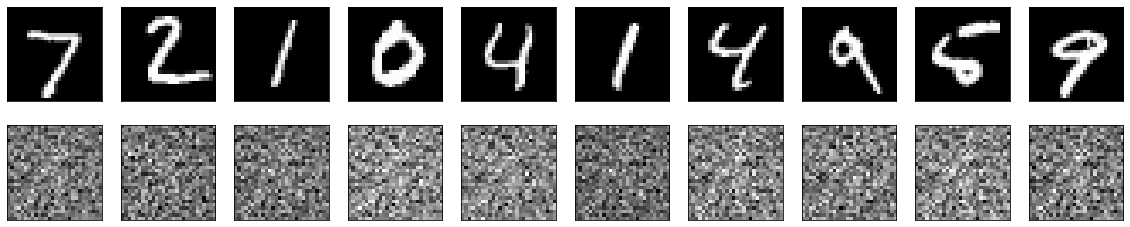

In [14]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [1]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [2]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [3]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [4]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

Using TensorFlow backend.


In [5]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print (x_train.shape)
print (x_test.shape)

(60000, 784)
(10000, 784)


In [6]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 47us/sample - loss: 0.6938 - val_loss: 0.6937
Epoch 2/50
60000/60000 [==============================] - 2s 39us/sample - loss: 0.6936 - val_loss: 0.6936
Epoch 3/50
60000/60000 [==============================] - 2s 38us/sample - loss: 0.6935 - val_loss: 0.6934
Epoch 4/50
60000/60000 [==============================] - 2s 40us/sample - loss: 0.6933 - val_loss: 0.6933
Epoch 5/50
60000/60000 [==============================] - 2s 42us/sample - loss: 0.6932 - val_loss: 0.6931
Epoch 6/50
60000/60000 [==============================] - 3s 47us/sample - loss: 0.6930 - val_loss: 0.6930
Epoch 7/50
60000/60000 [==============================] - 3s 42us/sample - loss: 0.6929 - val_loss: 0.6928
Epoch 8/50
60000/60000 [==============================] - 2s 40us/sample - loss: 0.6928 - val_loss: 0.6927
Epoch 9/50
60000/60000 [==============================] - 3s 45us/sample - loss: 0.6926 - val_

In [7]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
# import keras
from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

np.random.seed(1337)

# MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Generate corrupted MNIST images by adding noise with normal dist
# centered at 0.5 and std=0.5
noise = np.random.normal(loc=0.5, scale=0.5, size=x_train.shape)
x_train_noisy = x_train + noise
noise = np.random.normal(loc=0.5, scale=0.5, size=x_test.shape)
x_test_noisy = x_test + noise

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# Network parameters
input_shape = (image_size, image_size, 1)
batch_size = 128
kernel_size = 3
latent_dim = 16
# Encoder/Decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

# Build the Autoencoder Model
# First build the Encoder Model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# Stack of Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use MaxPooling2D as alternative to strides>1
# - faster but not as good as strides>1
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

# Shape info needed to build Decoder Model
shape = K.int_shape(x)

# Generate the latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# Instantiate Encoder Model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

# Build the Decoder Model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# Stack of Transposed Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use UpSampling2D as alternative to strides>1
# - faster but not as good as strides>1
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

x = Conv2DTranspose(filters=1,
                    kernel_size=kernel_size,
                    padding='same')(x)

outputs = Activation('sigmoid', name='decoder_output')(x)

# Instantiate Decoder Model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# Autoencoder = Encoder + Decoder
# Instantiate Autoencoder Model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

autoencoder.compile(loss='mse', optimizer='adam')

# Train the autoencoder
autoencoder.fit(x_train_noisy,
                x_train,
                validation_data=(x_test_noisy, x_test),
                epochs=30,
                batch_size=batch_size)

# Predict the Autoencoder output from corrupted test images
x_decoded = autoencoder.predict(x_test_noisy)

# Display the 1st 8 corrupted and denoised images
rows, cols = 10, 30
num = rows * cols
imgs = np.concatenate([x_test[:num], x_test_noisy[:num], x_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)
plt.figure()
plt.axis('off')
plt.title('Original images: top rows, '
          'Corrupted Input: middle rows, '
          'Denoised Input:  third rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
Image.fromarray(imgs).save('corrupted_and_denoised.png')
plt.show()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Sh

<Figure size 640x480 with 1 Axes>

In [8]:
%matplotlib inline  

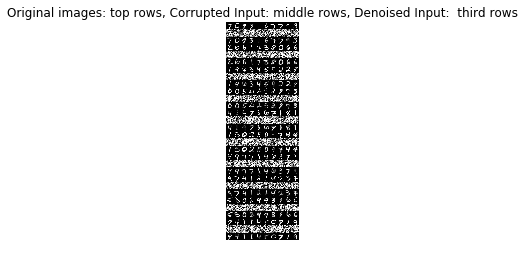

In [10]:
# Predict the Autoencoder output from corrupted test images
x_decoded = autoencoder.predict(x_test_noisy)

# Display the 1st 8 corrupted and denoised images
rows, cols = 10, 10
num = rows * cols
imgs = np.concatenate([x_test[:num], x_test_noisy[:num], x_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)
plt.figure()
plt.axis('off')
plt.title('Original images: top rows, '
          'Corrupted Input: middle rows, '
          'Denoised Input:  third rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
Image.fromarray(imgs).save('corrupted_and_denoised.png')
plt.show()

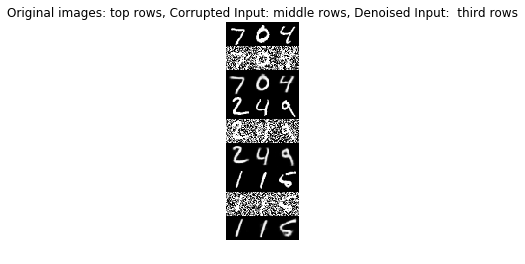

In [11]:
# Display the 1st 8 corrupted and denoised images
rows, cols = 3, 3
num = rows * cols
imgs = np.concatenate([x_test[:num], x_test_noisy[:num], x_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)
plt.figure()
plt.axis('off')
plt.title('Original images: top rows, '
          'Corrupted Input: middle rows, '
          'Denoised Input:  third rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
Image.fromarray(imgs).save('corrupted_and_denoised.png')
plt.show()

In [1]:
import tensorflow.keras as keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense,BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import regularizers

In [116]:
def extract_data(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(28 * 28 * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, 28,28)
        return data

In [117]:
train_data = extract_data('train-images-idx3-ubyte.gz', 60000)
test_data = extract_data('t10k-images-idx3-ubyte.gz', 10000)

In [118]:
def extract_labels(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        return labels

In [119]:
train_labels = extract_labels('train-labels-idx1-ubyte.gz',60000)
test_labels = extract_labels('t10k-labels-idx1-ubyte.gz',10000)

In [120]:
# Shapes of training set
print("Training set (images) shape: {shape}".format(shape=train_data.shape))

# Shapes of test set
print("Test set (images) shape: {shape}".format(shape=test_data.shape))

Training set (images) shape: (60000, 28, 28)
Test set (images) shape: (10000, 28, 28)


In [7]:
# Create dictionary of target classes
label_dict = {
 0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
}

Text(0.5, 1.0, '(Label: H)')

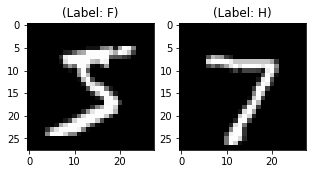

In [8]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(train_data[0], (28,28))
curr_lbl = train_labels[0]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(test_data[0], (28,28))
curr_lbl = test_labels[0]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

In [9]:
train_data = train_data.reshape(-1, 28,28, 1)
test_data = test_data.reshape(-1, 28,28, 1)
train_data.shape, test_data.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [10]:
train_data.dtype, test_data.dtype


(dtype('float32'), dtype('float32'))

In [11]:
np.max(train_data), np.max(test_data)

(255.0, 255.0)

In [12]:
train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)

In [13]:
np.max(train_data), np.max(test_data)

(1.0, 1.0)

In [14]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,
                                                             train_data, 
                                                             test_size=0.2, 
                                                             random_state=13)

In [15]:
batch_size = 128
epochs = 50
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))

In [16]:
def autoencoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)

    #decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 128
    up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
    up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [17]:
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [18]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         147584

In [19]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 222s 5ms/sample - loss: 0.1123 - val_loss: 0.1123
Epoch 2/50
48000/48000 [==============================] - 287s 6ms/sample - loss: 0.1119 - val_loss: 0.1123
Epoch 3/50
48000/48000 [==============================] - 250s 5ms/sample - loss: 0.1119 - val_loss: 0.1123
Epoch 4/50
48000/48000 [==============================] - 266s 6ms/sample - loss: 0.1119 - val_loss: 0.1123
Epoch 5/50
48000/48000 [==============================] - 280s 6ms/sample - loss: 0.1119 - val_loss: 0.1123
Epoch 6/50
48000/48000 [==============================] - 243s 5ms/sample - loss: 0.1119 - val_loss: 0.1123
Epoch 7/50
48000/48000 [==============================] - 238s 5ms/sample - loss: 0.1119 - val_loss: 0.1123
Epoch 8/50
48000/48000 [==============================] - 241s 5ms/sample - loss: 0.1119 - val_loss: 0.1123
Epoch 9/50
48000/48000 [==============================] - 244s 5ms/sample - loss: 0.11

KeyboardInterrupt: 

In [120]:
def autoencoder(input_img):
    #encoder
    #input = 784*1
    fc1 = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(input_img) # images*256
#     do1 = Dropout(0.25)(fc1)
    fc2 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(fc1)
    bn1 = BatchNormalization()(fc2)
    fc3 = Dense(64)(bn1)
    
    # decoder
    fc4 = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(bn1)
    fc5 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(fc4)
#     do2 = Dropout(0.25)(fc5)
    bn2 = BatchNormalization()(fc5)
    decoded = Dense(784, activation='relu', kernel_regularizer=regularizers.l2(0.01))(bn2)
    
    return decoded

In [121]:
(train_data, train_label), (test_data, test_label) = keras.datasets.mnist.load_data()

In [122]:
np.prod(train_data.shape[1:])

784

In [123]:
train_data = np.reshape(train_data, [-1, np.prod(train_data.shape[1:])])
test_data = np.reshape(test_data, [-1, np.prod(train_data.shape[1:])])
train_data = train_data.astype('float32') / 255
test_data = test_data.astype('float32') / 255

In [124]:
batch_size = 50
epochs = 50
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (784,))

In [125]:
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mse', optimizer = 'adam')

In [126]:
autoencoder.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_46 (Dense)             (None, 256)               200960    
_________________________________________________________________
dense_47 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_v2_17 (B (None, 128)               512       
_________________________________________________________________
dense_49 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_50 (Dense)             (None, 128)               8320      
_________________________________________________________________
batch_normalization_v2_18 (B (None, 128)               512 

In [127]:
autoencoder_train = autoencoder.fit(train_data, train_data, 
                                    batch_size=batch_size,epochs=epochs,verbose=1, shuffle=True,
                                    validation_data=(test_data, test_data))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 9s 157us/sample - loss: 0.1068 - val_loss: 0.0410
Epoch 2/50
60000/60000 [==============================] - 9s 147us/sample - loss: 0.0397 - val_loss: 0.0373
Epoch 3/50
60000/60000 [==============================] - 9s 147us/sample - loss: 0.0365 - val_loss: 0.0347
Epoch 4/50
60000/60000 [==============================] - 9s 148us/sample - loss: 0.0345 - val_loss: 0.0329
Epoch 5/50
60000/60000 [==============================] - 9s 149us/sample - loss: 0.0329 - val_loss: 0.0317
Epoch 6/50
60000/60000 [==============================] - 13s 218us/sample - loss: 0.0312 - val_loss: 0.0329
Epoch 7/50
60000/60000 [==============================] - 13s 222us/sample - loss: 0.0297 - val_loss: 0.0285
Epoch 8/50
60000/60000 [==============================] - 13s 215us/sample - loss: 0.0284 - val_loss: 0.0276
Epoch 9/50
60000/60000 [==============================] - 11s 175us/sample - loss: 

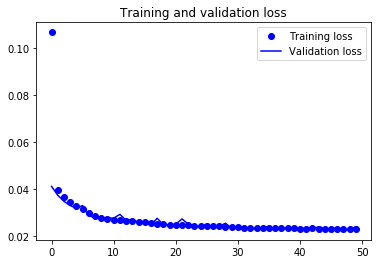

In [128]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs_ = range(epochs)
plt.figure()
plt.plot(epochs_, loss, 'bo', label='Training loss')
plt.plot(epochs_, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [129]:
pred = autoencoder.predict(test_data)

In [130]:
pred[0].shape

(784,)

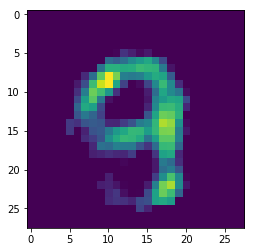

In [131]:
plt.imshow(pred[99].reshape(28,28))

Test Images


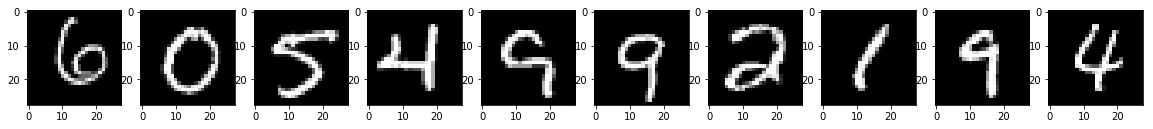

Reconstruction of Test Images


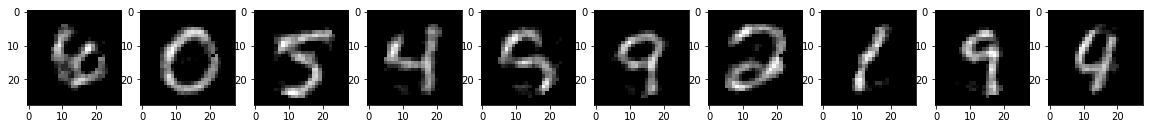

In [132]:
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(test_data[i+100].reshape(28,28), cmap='gray')
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i+100].reshape(28,28), cmap='gray')  
plt.show()

In [160]:
def conv_autoencoder(input_img):
    c1 = Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
    mp1 = MaxPooling2D((2, 2), padding='same')(c1)
    c2 = Conv2D(16, (3,3), activation='relu', padding='same')(mp1)
    mp2 = MaxPooling2D((2, 2), padding='same')(c2)
    c3 = Conv2D(16, (3,3), activation='relu', padding='same')(mp2)
    encoded = MaxPooling2D((2,2), padding='same')(c3)
    
    # at this point the representation is (4, 4, 8) i.e. 128-dimensional
    c4 = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
    up1 = UpSampling2D((2, 2))(c4)
    c5 = Conv2D(16, (3, 3), activation='relu', padding='same')(up1)
    up2 = UpSampling2D((2, 2))(c5)
    c6 = Conv2D(32, (3, 3), activation='relu')(up2)
    up3 = UpSampling2D((2, 2))(c6)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up3)
    
    return decoded

In [161]:
(train_data, train_label), (test_data, test_label) = keras.datasets.mnist.load_data()

In [162]:
train_data.shape

(60000, 28, 28)

In [163]:
train_data = train_data.astype('float32') / 255.
test_data = test_data.astype('float32') / 255.
train_data = np.reshape(train_data, (len(train_data), 28, 28, 1))  # adapt this if using `channels_first` image data format
test_data = np.reshape(test_data, (len(test_data), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [164]:
batch_size = 128
epochs = 10
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))

In [165]:
autoencoder = Model(input_img, conv_autoencoder(input_img))
autoencoder.compile(loss='mse', optimizer = 'adam')

In [166]:
autoencoder.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 16)        4624      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 16)          2320      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 16)          0  

In [167]:
from tensorflow.keras.callbacks import TensorBoard

autoencoder.fit(train_data, train_data,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(test_data, test_data),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 113s 2ms/sample - loss: 0.1153 - val_loss: 0.1140
Epoch 2/10
60000/60000 [==============================] - 112s 2ms/sample - loss: 0.1120 - val_loss: 0.1140
Epoch 3/10
60000/60000 [==============================] - 117s 2ms/sample - loss: 0.1120 - val_loss: 0.1140
Epoch 4/10
60000/60000 [==============================] - 145s 2ms/sample - loss: 0.1120 - val_loss: 0.1140
Epoch 5/10
60000/60000 [==============================] - 103s 2ms/sample - loss: 0.1120 - val_loss: 0.1140
Epoch 6/10
60000/60000 [==============================] - 86s 1ms/sample - loss: 0.1120 - val_loss: 0.1140
Epoch 7/10
60000/60000 [==============================] - 87s 1ms/sample - loss: 0.1120 - val_loss: 0.1140
Epoch 8/10
60000/60000 [==============================] - 86s 1ms/sample - loss: 0.1120 - val_loss: 0.1140
Epoch 9/10
60000/60000 [==============================] - 86s 1ms/sample - loss: 0.1120 -

In [154]:
decoded_imgs = autoencoder.predict(test_data)

In [155]:
decoded_imgs.shape

(10000, 28, 28, 1)

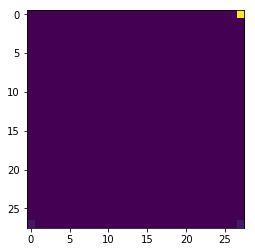

In [158]:
plt.imshow(decoded_imgs[1].reshape(28, 28))

Test Images


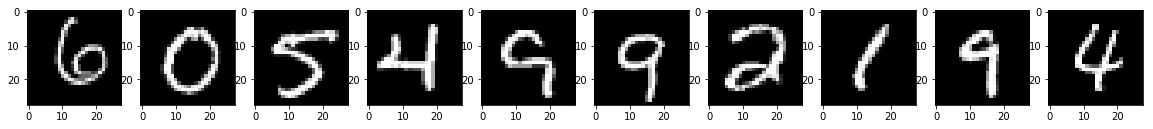

Reconstruction of Test Images


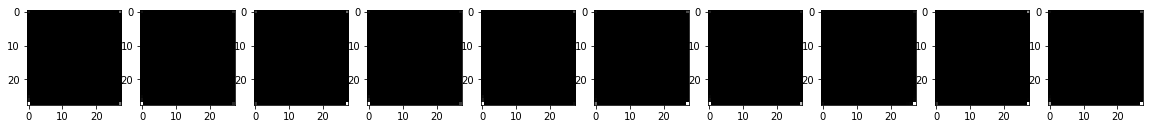

In [159]:
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(test_data[i+100].reshape(28,28), cmap='gray')
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(decoded_imgs[i+100].reshape(28,28), cmap='gray')  
plt.show()